# Introduction and Schema Diagram
The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases.

A schema diagram will help us understand the available columns and the structure of the data. Here's a schema diagram for the Chinook database:

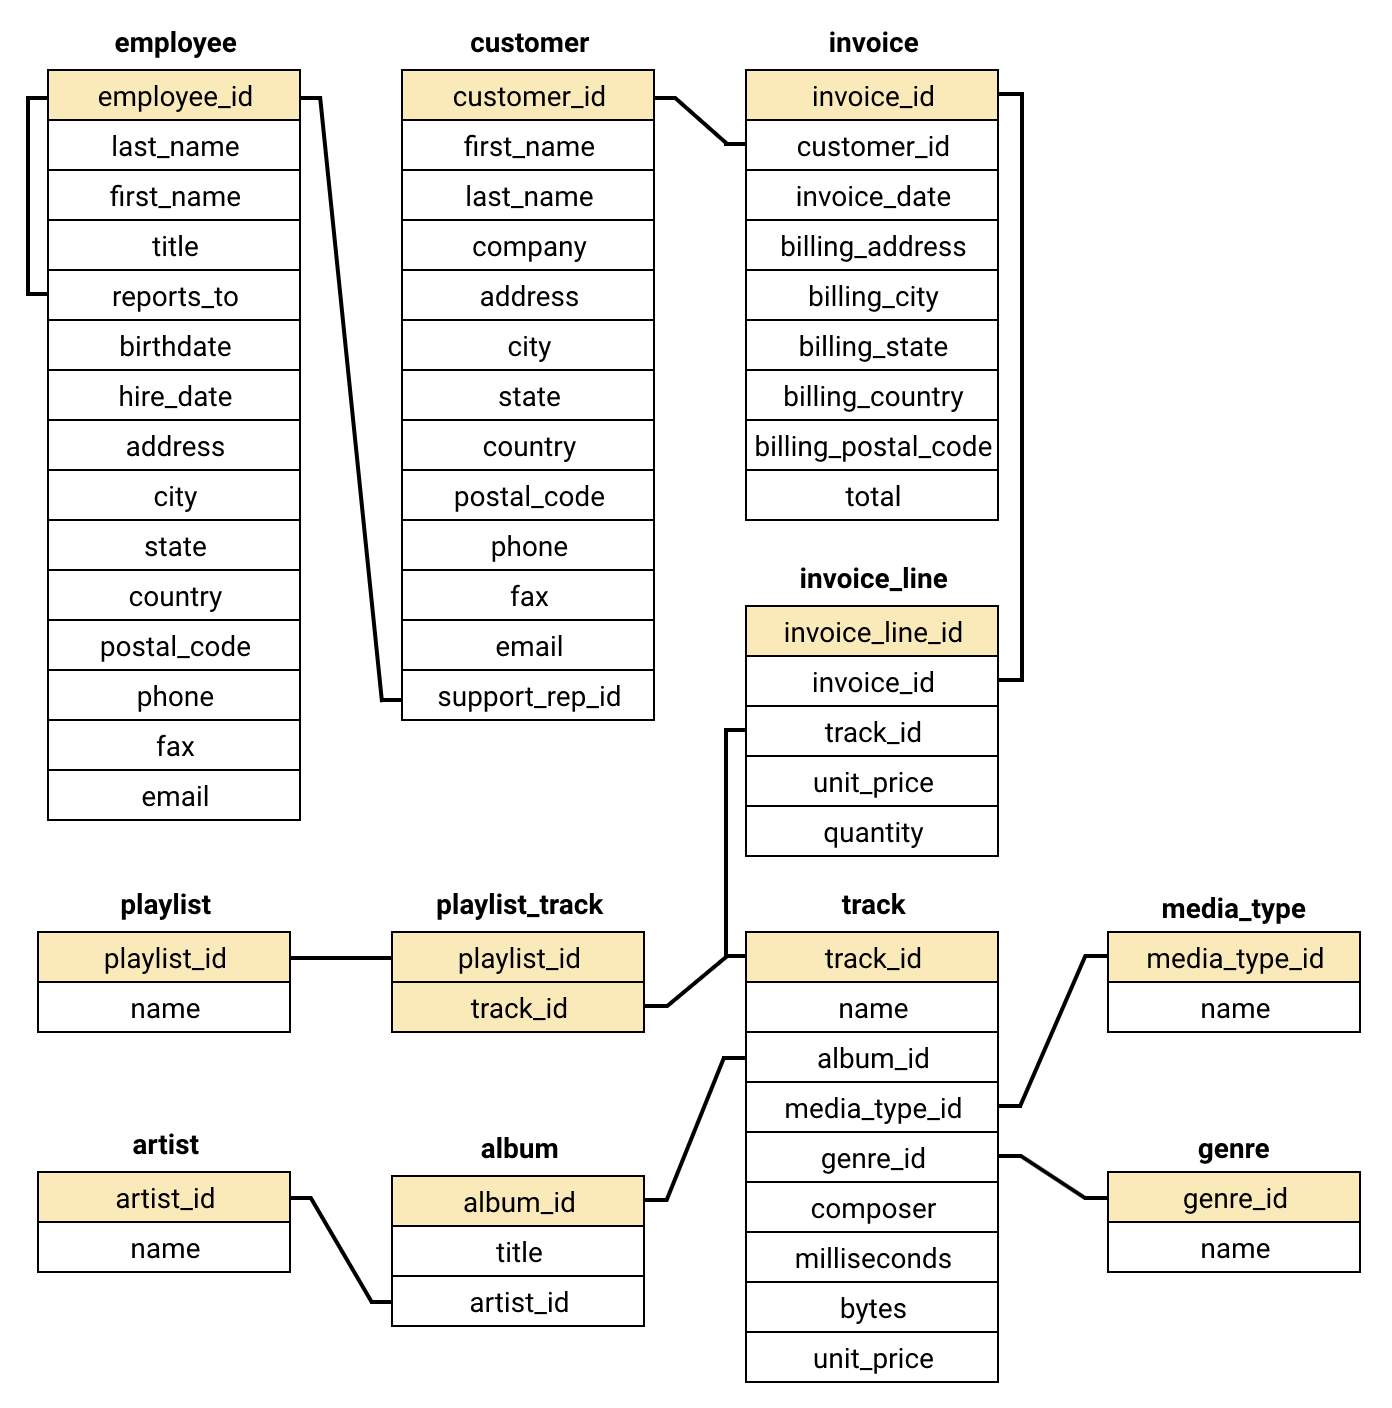

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

## Overview of the data

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Selecting New Albums to purchase

In [3]:
%%sql
With usa_tracks_sold as(
SELECT il.* from invoice_line il
inner JOIN invoice i ON il.invoice_id = i.invoice_id
inner JOIN customer c ON c.customer_id = i.customer_id
where c.country = "USA")

SELECT
g.name genre,
count(uts.invoice_id) tracks_sold,
cast(count(uts.invoice_id) AS float) / (
SELECT COUNT(*) from usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
inner JOIN track t ON uts.track_id = t.track_id
inner JOIN genre g ON t.genre_id = g.genre_id
Group BY 1
order by 2 desc
Limit 10

Done.


genre,tracks_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Latin,22,0.02093244529019981
Pop,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing employee sales performance

In [4]:
%%sql
With support_rep_sales as (
    SELECT 
    c.customer_id,
    c.support_rep_id,
    SUM(i.total) total
    from customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    group By 1)
    
SELECT e.first_name || ' ' || e.last_name employee_name,
SUM(srs.total) total,
e.hire_date
from support_rep_sales srs
inner Join employee e ON srs.support_rep_id = e.employee_id
Group By 1
Having e.title = "Sales Support Agent"

Done.


employee_name,total,hire_date
Jane Peacock,1731.5099999999998,2017-04-01 00:00:00
Margaret Park,1584.0000000000002,2017-05-03 00:00:00
Steve Johnson,1393.92,2017-10-17 00:00:00


While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

In [5]:
%%sql
with customer_invoices AS
     (
         SELECT c.customer_id,
                c.country,
                COUNT(i.invoice_id) orders,
                SUM(i.total) total_sales
         FROM customer c
         INNER JOIN invoice AS i on c.customer_id = i.customer_id
         GROUP BY 1
     ),
    country_statistics AS
    (
        SELECT CASE
                 WHEN COUNT(customer_id) = 1 THEN 'Other' 
                 ELSE country
                 END AS country,
               COUNT(customer_id) total_customers,
               SUM(orders) total_orders,
               SUM(total_sales) total_sales
        FROM customer_invoices
        GROUP BY country
     )
     SELECT
        country,
        SUM(total_customers) total_customers,
        round(SUM(total_sales),2) total_sales,
        round(SUM(total_sales)/ SUM(total_customers),2) average_sales_per_customer,
        round(SUM(total_sales)/ SUM(total_orders),2) average_order_value
        FROM country_statistics
        GROUP BY country
        Order by Case
          WHEN COUNTRY = 'Other' THEN 1
            Else 0
            END,
            total_sales desc

Done.


country,total_customers,total_sales,average_sales_per_customer,average_order_value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.56,6.38
India,2,183.15,91.57,8.72
Other,15,1094.94,73.0,7.45


Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [6]:
%%sql
WITH invoice_album AS
(
    SELECT 
        il.invoice_id,                                     
        t.album_id
        FROM invoice_line il
        LEFT JOIN track t 
        ON t.track_id = il.track_id
        GROUP BY 1
),

album_vs_tracks AS 
(
    SELECT 
        ia.*,
        CASE
        WHEN(
            (SELECT il.track_id 
             FROM invoice_line il
             WHERE il.invoice_id = ia.invoice_id
             EXCEPT                                          
             SELECT t.track_id 
             FROM track t
             WHERE t.album_id = ia.album_id) IS NULL
        AND 
            (SELECT t.track_id 
             FROM track t
             WHERE t.album_id = ia.album_id                                         
             EXCEPT                                          
             SELECT il.track_id 
             FROM invoice_line il
             WHERE il.invoice_id = ia.invoice_id) IS NULL)

        THEN "Albums"
        ELSE "Tracks"
        END AS purchase                             
    FROM invoice_album ia)

SELECT
    purchase,
    COUNT(*) num_invoices,
    ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*) FROM invoice), 2) pct
FROM album_vs_tracks
GROUP BY 1
ORDER BY 2 DESC;

Done.


purchase,num_invoices,pct
Tracks,500,81.43
Albums,114,18.57


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.